Se importan todas las librerías necesarias para el procesamiento de datos, visualización, modelado y recursos de NLTK para el procesamiento de texto.

In [17]:
import pandas as pd # procesamiento de datos
pd.options.mode.chained_assignment = None  # predeterminado='warn'
import matplotlib.pyplot as plt #Propiedades de gráficos
import seaborn as sns #Propiedades de gráficos
from sklearn.feature_extraction.text import CountVectorizer #Transformación de datos
from sklearn.model_selection import train_test_split #División de datos
from sklearn.linear_model import LogisticRegression #Modelo de predicción
from sklearn.metrics import accuracy_score #Comparación entre real y predicho
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder #Codificación y decodificación de variables para XGBoost
import re #Expresiones regulares
import nltk
from nltk import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/matias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Se cargan los datasets de entrenamiento y validación, se renombran las columnas y se realiza el preprocesamiento básico de los textos: conversión a minúsculas, conversión a string y limpieza de caracteres especiales usando expresiones regulares.

In [18]:
# Carga de datos
datos_validacion = pd.read_csv("data/twitter_validation.csv", header=None)
datos_entrenamiento = pd.read_csv("data/twitter_training.csv", header=None)
datos_validacion.columns = ['id', 'informacion', 'tipo', 'texto']
datos_entrenamiento.columns = ['id', 'informacion', 'tipo', 'texto']

# Transformación de texto
datos_entrenamiento["minusculas"] = datos_entrenamiento.texto.str.lower() #minúsculas
datos_entrenamiento["minusculas"] = [str(dato) for dato in datos_entrenamiento.minusculas] #convertir a string
datos_entrenamiento["minusculas"] = datos_entrenamiento.minusculas.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex
datos_validacion["minusculas"] = datos_validacion.texto.str.lower() #minúsculas
datos_validacion["minusculas"] = [str(dato) for dato in datos_validacion.minusculas] #convertir a string
datos_validacion["minusculas"] = datos_validacion.minusculas.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex

datos_entrenamiento.head()

,id,informacion,tipo,texto,minusculas
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


Se genera un gráfico de barras para visualizar la distribución de tweets por marca (`information`) y tipo (`type`), permitiendo analizar el balance de clases en el dataset.

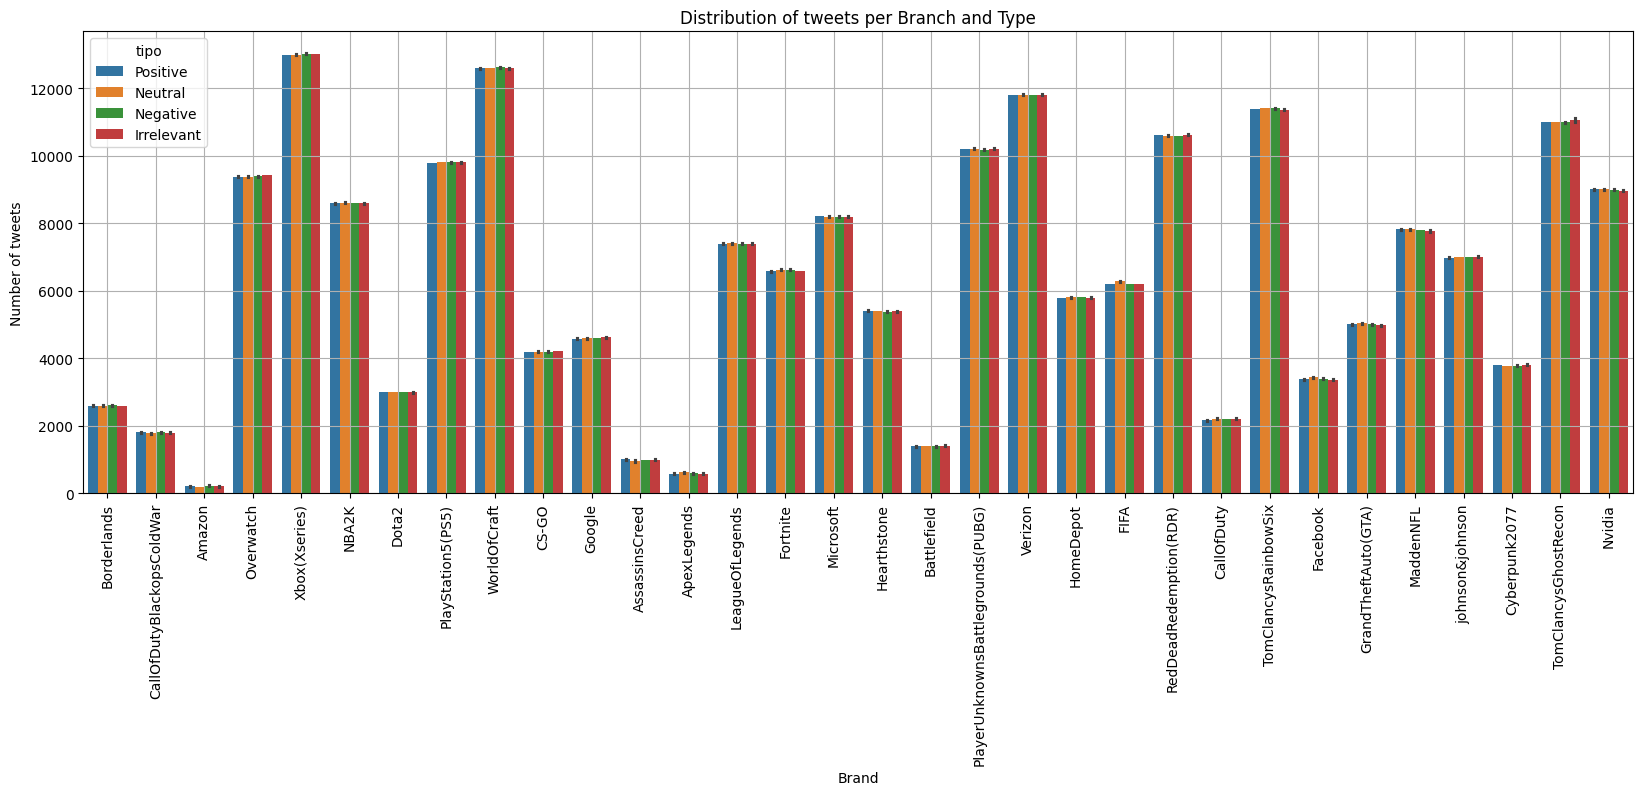

In [19]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=datos_entrenamiento,x="informacion",y="id",hue="tipo")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type");

Se tokenizan los textos, se cuentan las palabras únicas y se seleccionan las stopwords en inglés. Luego, se crea un vectorizador de palabras (Bag of Words) usando `CountVectorizer` con tokenización personalizada y eliminación de stopwords.

In [20]:
#Text splitting
tokens_text = [word_tokenize(str(word)) for word in datos_entrenamiento.minusculas]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

#Choosing english   
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:5]

#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, #English Stopwords
    ngram_range=(1, 1) #analysis of one word
)

Number of tokens:  30436


Se divide el dataset en entrenamiento y prueba, se vectorizan los textos, se extraen las etiquetas y se entrena un modelo de regresión logística para clasificación de sentimientos.

In [21]:
# División de entrenamiento y prueba
entrenamiento, prueba = train_test_split(datos_entrenamiento, test_size=0.2, random_state=0)
X_entrenamiento_bow = bow_counts.fit_transform(entrenamiento.minusculas)
X_prueba_bow = bow_counts.transform(prueba.minusculas)

y_entrenamiento_bow = entrenamiento['tipo']
y_prueba_bow = prueba['tipo']

print("Total de registros por categoría:\n", y_prueba_bow.value_counts() / y_prueba_bow.shape[0])

# Regresión logística
modelo1 = LogisticRegression(C=1, solver="liblinear", max_iter=200)
modelo1.fit(X_entrenamiento_bow, y_entrenamiento_bow)

/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Total de registros por categoría:
 tipo
Negative      0.299190
Positive      0.282252
Neutral       0.245632
Irrelevant    0.172926
Name: count, dtype: float64


/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,200
,multi_class,'deprecated'


Se realizan predicciones sobre los datos de prueba y validación, mostrando la precisión obtenida en ambos conjuntos para evaluar el desempeño del modelo entrenado.

In [22]:
# Predicción
prediccion_prueba = modelo1.predict(X_prueba_bow)
print("Precisión en prueba: ", accuracy_score(y_prueba_bow, prediccion_prueba) * 100)

X_validacion_bow = bow_counts.transform(datos_validacion.minusculas)
y_validacion_bow = datos_validacion['tipo']

resultado_validacion = modelo1.predict(X_validacion_bow)
print("Precisión en validación: ", accuracy_score(y_validacion_bow, resultado_validacion) * 100)

Precisión en prueba:  81.50900448550578
Precisión en validación:  91.7


Se crea un nuevo vectorizador usando n-gramas de 1 a 4 palabras, se vectorizan los textos y se entrena un segundo modelo de regresión logística para comparar el impacto de los n-gramas en el desempeño.

In [23]:
#n-gram of 4 words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)
#Data labeling
X_train_bow = bow_counts.fit_transform(entrenamiento.minusculas)
X_test_bow = bow_counts.transform(prueba.minusculas)
X_val_bow = bow_counts.transform(datos_validacion.minusculas)

model2 = LogisticRegression(C=0.9, solver="liblinear",max_iter=1500)
# Logistic regression
model2.fit(X_train_bow, y_entrenamiento_bow)


/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.9
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1500
,multi_class,'deprecated'


Se evalúa el segundo modelo (con n-gramas) sobre los datos de prueba y validación, mostrando la precisión obtenida para comparar con el modelo anterior.

In [24]:
# Prediction
test_pred_2 = model2.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_prueba_bow, test_pred_2) * 100)

y_val_bow = datos_validacion['tipo']
Val_pred_2 = model2.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_pred_2) * 100)

Accuracy:  90.79467095132891
Accuracy:  98.6


## XGBoost

Se codifican las etiquetas numéricamente y se entrena un modelo XGBoost para clasificación multiclase. Se evalúa el desempeño del modelo sobre los datos de prueba y validación.

In [25]:
le = LabelEncoder()
y_train_bow_num = le.fit_transform(y_entrenamiento_bow)
y_test_bow_num = le.transform(y_prueba_bow)
y_val_bow_num = le.transform(y_val_bow)

XGB = XGBClassifier(objective="multi:softmax", n_estimators=1000, colsample_bytree=0.6, subsample=0.6)
XGB.fit(X_train_bow, y_train_bow_num)
# Prediction
test_pred_2 = XGB.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow_num, test_pred_2) * 100)

y_val_bow = datos_validacion['tipo']
Val_pred_2 = XGB.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow_num, Val_pred_2) * 100)

Accuracy:  84.84970208207805
Accuracy:  96.2
